# Movie Lens

In [12]:
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv("../datasets/ml-100k/u.data.csv",sep="\t",header=None,names=["UserId","ItemId","Rating","TimeStamp"])
df.head()

,UserId,ItemId,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# ExploratoryAnalysis

In [4]:
import matplotlib.pyplot as plt

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

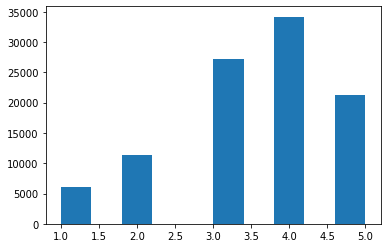

In [5]:
plt.hist(df.Rating)

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <a list of 10 Patch objects>)

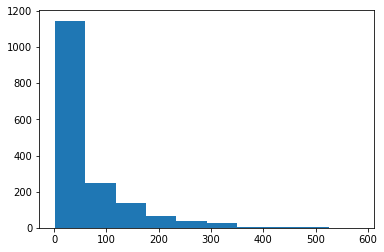

In [6]:
# Cuanta gente a visto la pelicula ith
plt.hist(df.groupby(["ItemId"])["ItemId"].count())

# Representacion en forma matricial

In [10]:
n_users = df.UserId.unique().shape[0]
n_items = df.ItemId.unique().shape[0]
print("Usuarios unicos: ", n_users)
print("Items unicos: ", n_items)

Usuarios unicos:  943
Items unicos:  1682


In [13]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

In [14]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [17]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1])
sparsity*=100
# Cuántos datos tenemos que sean no zero
print("Coeficiente de sparseidad: {:4.2f}%".format(sparsity))

Coeficiente de sparseidad: 6.30%


# Crear Set de train y test

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
ratings_tr, ratings_ts = train_test_split(ratings,test_size=.3,random_state=42)

In [20]:
ratings_tr.shape

(660, 1682)

In [21]:
ratings_ts.shape

(283, 1682)

# Filtro colaborativo basado en Usuarios
* Matriz de similaridad entre usuarios (distancia del coseno)
* Predecir la valoración desconocida de un item $ i $ para un usuario activo $ u $ basándonos en la suma ponderada de todas las valoraciones del resto de los usuarios (más parecidos al usuario $u$, o los $k$ más parecidos) para dicho item $i$.

In [22]:
import numpy as np
import sklearn

In [23]:
# ~ 1 Muy similares
# ~ 0 Muy distintos
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_tr)
sim_matrix.shape

(660, 660)

In [31]:
sim_matrix_ts = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_ts)
sim_matrix_ts.shape

(283, 283)

In [24]:
sim_matrix

array([[1.        , 0.17448349, 0.18009754, ..., 0.13331459, 0.17695593,
        0.21882481],
       [0.17448349, 1.        , 0.07993097, ..., 0.07175808, 0.09552622,
        0.05512655],
       [0.18009754, 0.07993097, 1.        , ..., 0.0191736 , 0.02233385,
        0.10310785],
       ...,
       [0.13331459, 0.07175808, 0.0191736 , ..., 1.        , 0.04853428,
        0.05142508],
       [0.17695593, 0.09552622, 0.02233385, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.21882481, 0.05512655, 0.10310785, ..., 0.05142508, 0.1198022 ,
        1.        ]])

In [25]:
users_predictions = sim_matrix.dot(ratings_tr) / np.array([np.abs(sim_matrix).sum(axis=1)]).T

In [32]:
users_predictions_ts = sim_matrix_ts.dot(ratings_ts) / np.array([np.abs(sim_matrix_ts).sum(axis=1)]).T

In [26]:
users_predictions

array([[2.10259747e+00, 5.86975978e-01, 3.40264192e-01, ...,
        0.00000000e+00, 7.33611460e-03, 6.04379414e-03],
       [1.40999723e+00, 2.91863934e-01, 2.68085289e-01, ...,
        0.00000000e+00, 3.50378592e-03, 2.32963985e-03],
       [1.69014833e+00, 3.13648440e-01, 3.26127887e-01, ...,
        0.00000000e+00, 3.25391767e-03, 1.77210119e-03],
       ...,
       [1.73393747e+00, 4.06719333e-01, 3.21166908e-01, ...,
        0.00000000e+00, 2.71269625e-03, 9.00511411e-03],
       [2.34361031e+00, 8.10544770e-01, 4.73941025e-01, ...,
        0.00000000e+00, 1.01130066e-02, 9.66427605e-03],
       [2.36796969e+00, 5.98146138e-01, 3.85569804e-01, ...,
        0.00000000e+00, 6.39996638e-03, 5.37442746e-03]])

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
def get_mse(preds, actuals):
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [29]:
get_mse(users_predictions, ratings_tr)

7.878218313143215

In [33]:
get_mse(users_predictions_ts, ratings_ts)

7.51355110112698

# Filtro colaborativo basado en KNN

In [34]:
from sklearn.neighbors import NearestNeighbors

In [35]:
k = 10

In [36]:
neigs = NearestNeighbors(k, "cosine").fit(ratings_tr)

In [37]:
top_k_dist, top_k_users = neigs.kneighbors(ratings_tr,return_distance=True)
top_k_dist.shape

(660, 10)

In [38]:
top_k_users[0]

array([  0, 211,  16, 428, 583, 279, 149, 188, 196, 424])

In [39]:
users_predicts_k = np.zeros(ratings_tr.shape)
for i in range(ratings_tr.shape[0]):
    users_predicts_k[i,:]=top_k_dist[i].T.dot(ratings_tr[top_k_users][i])/np.array([np.abs(top_k_dist[i].T).sum(axis=0)]).T


In [40]:
users_predicts_k.shape

(660, 1682)

In [41]:
users_predicts_k

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66502836, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.31240293, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [42]:
get_mse(users_predicts_k, ratings_tr)

8.229125487414281

# Filtro colaborativo basado en items